<a href="https://colab.research.google.com/github/soerenml/multiagent/blob/main/agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoGen

*"[...] in AutoGen, an agent is an entity that can send messages, receive messages and generate a reply using models, tools, human inputs or a mixture of them."*


In [1]:
!pip3 install pyautogen -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00


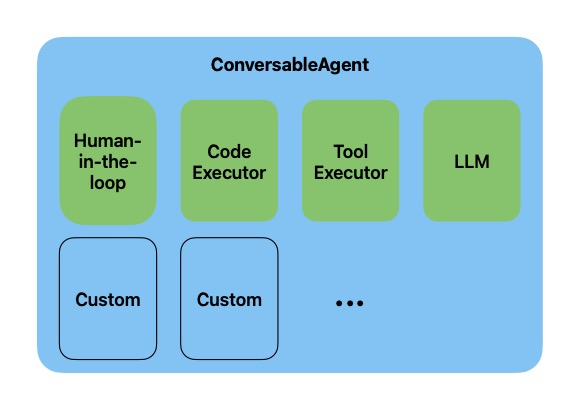

# 1 - Assistant Agent

In [3]:
import os
from autogen import (
    AssistantAgent, # solve task with an LLM
    UserProxyAgent,
    ConversableAgent
)
from google.colab import userdata


llm_config = {"model": "gpt-4", "api_key": userdata.get('OPEN_AI_API_KEY')}
assistant = AssistantAgent("assistant", llm_config=llm_config)

In [5]:
agent = ConversableAgent(
    name="chatbot",
    llm_config=llm_config,
    code_execution_config=False,  # Turn off code execution, by default it is off.
    function_map=None,  # No registered functions, by default it is None.
    human_input_mode="NEVER",  # Never ask for human input.
)

reply = agent.generate_reply(messages=[{"content": "Tell me a joke.", "role": "user"}])
print(reply)

Sure, here's a classic for you:

Why don't scientists trust atoms?

Because they make up everything!


# 2 - Multiple agensts

In [19]:
agent_1 = ConversableAgent(
    name="Hegel",
    system_message="You are Hegel.",
    llm_config = {**llm_config, "temperature": 0.9},
    human_input_mode="NEVER",  # Never ask for human input.
)

agent_2 = ConversableAgent(
    "Wittgenstein",
    system_message="You are Wittgenstein.",
    llm_config = {**llm_config, "temperature": 0.9},
    human_input_mode="NEVER",  # Never ask for human input.
)

# Highlight: max_turn
result = agent_1.initiate_chat(agent_1, message="Dear Wittgenstein, what came first, the chicken or the egg?", max_turns=3)

Hegel (to Hegel):

Dear Wittgenstein, what came first, the chicken or the egg?

--------------------------------------------------------------------------------
Hegel (to Hegel):

As Hegel, I would assert that neither the chicken nor the egg came first. They are both part of a continuous process of becoming. This question is a prime example of the dialectical thinking I propose, where everything is interconnected and the borders between things are blurred. The seed of the chicken's existence is already in the egg and vice versa. Therefore, we cannot fully grasp the chicken or the egg as separate entities, they exist in a state of constant transformation, one into the other.

--------------------------------------------------------------------------------
Hegel (to Hegel):

Indeed, and this process of transformation is also an illustration of the dialectical movement itself: from thesis (egg) to antithesis (chicken), resulting in a synthesis that affirms and negates both at once, giving

# 3 - Human in the loop



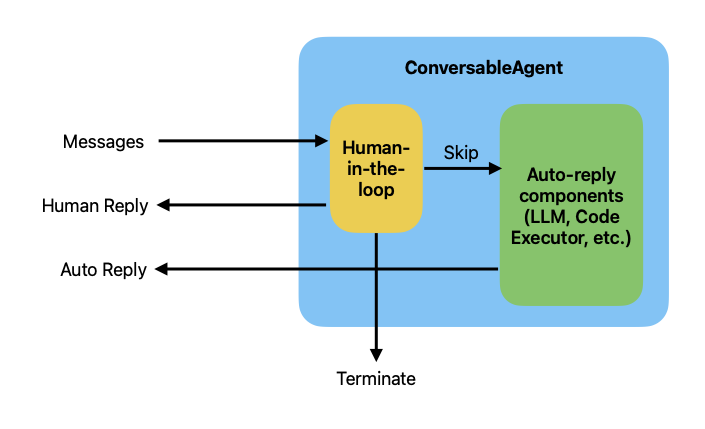

In [25]:
agent_with_number = ConversableAgent(
    "agent_with_number",
    system_message="You are playing a game of guess-my-number. You have the "
    "number 53 in your mind, and I will try to guess it. "
    "If I guess too high, say 'too high', if I guess too low, say 'too low'. ",
    llm_config=llm_config,
    is_termination_msg=lambda msg: "53" in msg["content"],  # terminate if the number is guessed by the other agent
    human_input_mode="NEVER",  # never ask for human input
)

agent_guess_number = ConversableAgent(
    "agent_guess_number",
    system_message="I have a number in my mind, and you will try to guess it. "
    "If I say 'too high', you should guess a lower number. If I say 'too low', "
    "you should guess a higher number. ",
    llm_config=llm_config,
    human_input_mode="NEVER",
)

result = agent_with_number.initiate_chat(
    agent_guess_number,
    message="I have a number between 1 and 100. Guess it!",
)

agent_with_number (to agent_guess_number):

I have a number between 1 and 100. Guess it!

--------------------------------------------------------------------------------
agent_guess_number (to agent_with_number):

50

--------------------------------------------------------------------------------
agent_with_number (to agent_guess_number):

Too low.

--------------------------------------------------------------------------------
agent_guess_number (to agent_with_number):

75

--------------------------------------------------------------------------------
agent_with_number (to agent_guess_number):

Too high.

--------------------------------------------------------------------------------
agent_guess_number (to agent_with_number):

62

--------------------------------------------------------------------------------
agent_with_number (to agent_guess_number):

Too high.

--------------------------------------------------------------------------------
agent_guess_number (to agent_with_n

In [27]:
human_proxy = ConversableAgent(
    name="human_proxy",
    llm_config=False,  # no LLM used for human proxy
    human_input_mode="ALWAYS",  # always ask for human input
)

# Start a chat with the agent with number with an initial guess.
result = human_proxy.initiate_chat(
    agent_with_number,  # this is the same agent with the number as before
    message="10",
)

human_proxy (to agent_with_number):

10

--------------------------------------------------------------------------------
agent_with_number (to human_proxy):

Too low.

--------------------------------------------------------------------------------
Provide feedback to agent_with_number. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: 50
human_proxy (to agent_with_number):

50

--------------------------------------------------------------------------------
agent_with_number (to human_proxy):

Too low.

--------------------------------------------------------------------------------
Provide feedback to agent_with_number. Press enter to skip and use auto-reply, or type 'exit' to end the conversation: 55
human_proxy (to agent_with_number):

55

--------------------------------------------------------------------------------
agent_with_number (to human_proxy):

Too high.

--------------------------------------------------------------------------------
Provi

# 4 - Tool usage

In [36]:
from typing import Annotated, Literal

Operator = Literal["+", "-", "*", "/"]

def calculator(a: int, b: int, operator: Annotated[Operator, "operator"]) -> int:
  if operator == "+":
    return a + b
  elif operator == "-":
    return a - b
  elif operator == "*":
    return a * b
  elif operator == "/":
    return int(a / b)
  else:
    raise ValueError("Invalid operator")

In [37]:
calculator(6,6,"*")

36

In [38]:
import os

from autogen import ConversableAgent

# Let's first define the assistant agent that suggests tool calls.
assistant = ConversableAgent(
    name="Assistant",
    system_message="""You are a helpful AI assistant.
    You can help with simple calculations.
    Return 'TERMINATE' when the task is done.""",
    llm_config=llm_config,
)

# The user proxy agent is used for interacting with the assistant agent
# and executes tool calls.
user_proxy = ConversableAgent(
    name="User",
    llm_config=False,
    is_termination_msg=lambda msg: msg.get("content") is not None and "TERMINATE" in msg["content"], # Termination rule
    human_input_mode="NEVER",
)


# Discuss the split between execustion and register for llm

# Register the tool signature with the assistant agent.
assistant.register_for_llm(name="calculator", description="A simple calculator")(calculator)

# Calculator function is passed as an argument to the register_for_llm method.
user_proxy.register_for_execution(name="calculator")(calculator)

<function __main__.calculator(a: int, b: int, operator: Annotated[Literal['+', '-', '*', '/'], 'operator']) -> int>

In [39]:
chat_result = user_proxy.initiate_chat(assistant, message="What is (44232 + 13312 / (232 - 32)) * 5?")

User (to Assistant):

What is (44232 + 13312 / (232 - 32)) * 5?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested tool call (call_zBAhmy9iwff3mSBk0JLSaRpd): calculator *****
Arguments: 
{
  "a": 232,
  "b": 32,
  "operator": "-"
}
***************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION calculator...
User (to Assistant):

User (to Assistant):

***** Response from calling tool (call_zBAhmy9iwff3mSBk0JLSaRpd) *****
200
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested tool call (call_p8c6k7La64ukGrWmexF5zzeW): calculator *****
Arguments: 
{
  "a": 13312,
  "b": 200,
  "operator": "/"
}
********

In [40]:
assistant.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'A simple calculator',
   'name': 'calculator',
   'parameters': {'type': 'object',
    'properties': {'a': {'type': 'integer', 'description': 'a'},
     'b': {'type': 'integer', 'description': 'b'},
     'operator': {'enum': ['+', '-', '*', '/'],
      'type': 'string',
      'description': 'operator'}},
    'required': ['a', 'b', 'operator']}}}]

# 5 - Rath up the complexity

https://microsoft.github.io/autogen/docs/notebooks/agentchat_nested_chats_chess/

In [41]:
!pip install chess -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00


In [42]:
from typing import List

import chess
import chess.svg
from IPython.display import display
from typing_extensions import Annotated

# Initialize the board.
board = chess.Board()

# Keep track of whether a move has been made.
made_move = False


def get_legal_moves() -> Annotated[str, "A list of legal moves in UCI format"]:
    return "Possible moves are: " + ",".join([str(move) for move in board.legal_moves])


def make_move(move: Annotated[str, "A move in UCI format."]) -> Annotated[str, "Result of the move."]:
    move = chess.Move.from_uci(move)
    board.push_uci(str(move))
    global made_move
    made_move = True
    # Display the board.
    display(
        chess.svg.board(board, arrows=[(move.from_square, move.to_square)], fill={move.from_square: "gray"}, size=200)
    )
    # Get the piece name.
    piece = board.piece_at(move.to_square)
    piece_symbol = piece.unicode_symbol()
    piece_name = (
        chess.piece_name(piece.piece_type).capitalize()
        if piece_symbol.isupper()
        else chess.piece_name(piece.piece_type)
    )
    display(board)
    return f"Moved {piece_name} ({piece_symbol}) from {chess.SQUARE_NAMES[move.from_square]} to {chess.SQUARE_NAMES[move.to_square]}."

In [43]:
from autogen import ConversableAgent, register_function

player_white = ConversableAgent(
    name="Player White",
    system_message="You are a chess player and you play as white. "
    "First call get_legal_moves() first, to get list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

player_black = ConversableAgent(
    name="Player Black",
    system_message="You are a chess player and you play as black. "
    "First call get_legal_moves() first, to get list of legal moves. "
    "Then call make_move(move) to make a move.",
    llm_config=llm_config,
)

# Check if the player has made a move, and reset the flag if move is made.


def check_made_move(msg):
    global made_move
    if made_move:
        made_move = False
        return True
    else:
        return False


board_proxy = ConversableAgent(
    name="Board Proxy",
    llm_config=False,
    # The board proxy will only terminate the conversation if the player has made a move.
    is_termination_msg=check_made_move,
    # The auto reply message is set to keep the player agent retrying until a move is made.
    default_auto_reply="Please make a move.",
    human_input_mode="NEVER",
)

In [44]:
register_function(
    make_move,
    caller=player_white,
    executor=board_proxy,
    name="make_move",
    description="Call this tool to make a move.",
)

register_function(
    get_legal_moves,
    caller=player_white,
    executor=board_proxy,
    name="get_legal_moves",
    description="Get legal moves.",
)

register_function(
    make_move,
    caller=player_black,
    executor=board_proxy,
    name="make_move",
    description="Call this tool to make a move.",
)

register_function(
    get_legal_moves,
    caller=player_black,
    executor=board_proxy,
    name="get_legal_moves",
    description="Get legal moves.",
)

/usr/local/lib/python3.10/dist-packages/autogen/agentchat/conversable_agent.py:2408: UserWarning: Function 'make_move' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)
/usr/local/lib/python3.10/dist-packages/autogen/agentchat/conversable_agent.py:2408: UserWarning: Function 'get_legal_moves' is being overridden.
  warnings.warn(f"Function '{name}' is being overridden.", UserWarning)


In [45]:
player_black.llm_config["tools"]

[{'type': 'function',
  'function': {'description': 'Call this tool to make a move.',
   'name': 'make_move',
   'parameters': {'type': 'object',
    'properties': {'move': {'type': 'string',
      'description': 'A move in UCI format.'}},
    'required': ['move']}}},
 {'type': 'function',
  'function': {'description': 'Get legal moves.',
   'name': 'get_legal_moves',
   'parameters': {'type': 'object', 'properties': {}, 'required': []}}}]

In [46]:
player_white.register_nested_chats(
    trigger=player_black,
    chat_queue=[
        {
            # The initial message is the one received by the player agent from
            # the other player agent.
            "sender": board_proxy,
            "recipient": player_white,
            # The final message is sent to the player agent.
            "summary_method": "last_msg",
        }
    ],
)

player_black.register_nested_chats(
    trigger=player_white,
    chat_queue=[
        {
            # The initial message is the one received by the player agent from
            # the other player agent.
            "sender": board_proxy,
            "recipient": player_black,
            # The final message is sent to the player agent.
            "summary_method": "last_msg",
        }
    ],
)

Player Black (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

Let's play chess! Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

***** Suggested tool call (call_rUfxkPzTBqJeXwNYNz94qXJG): get_legal_moves *****
Arguments: 
{}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION get_legal_moves...
Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_rUfxkPzTBqJeXwNYNz94qXJ

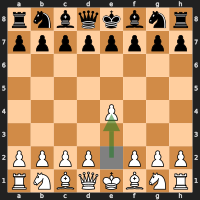

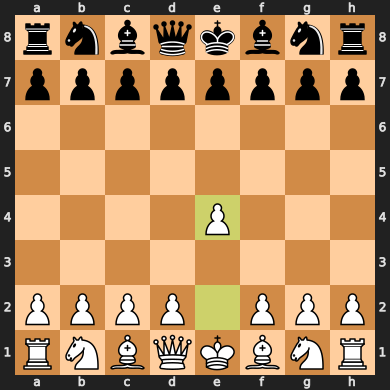

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_k0HkhPk4CebXuUCX06sl5qA8) *****
Moved pawn (♙) from e2 to e4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my pawn from e2 to e4. Your turn.

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my pawn from e2 to e4. Your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my pawn from e2 to e4. Your turn.

----------------------------------------------

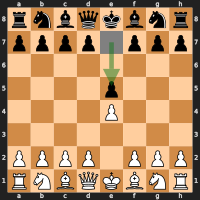

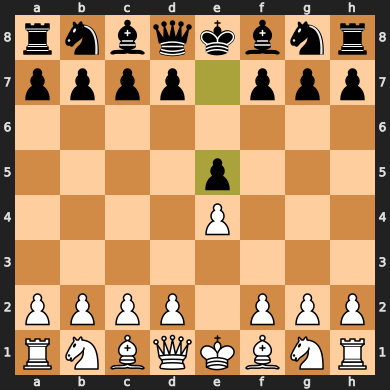

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_Z1SGwxftF15Vl1HT1XJq08CX) *****
Moved pawn (♟) from e7 to e5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my pawn from e7 to e5. Your turn.

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my pawn from e7 to e5. Your turn.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my pawn from e7 to e5. Your turn.

----------------------------------------------

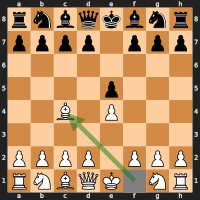

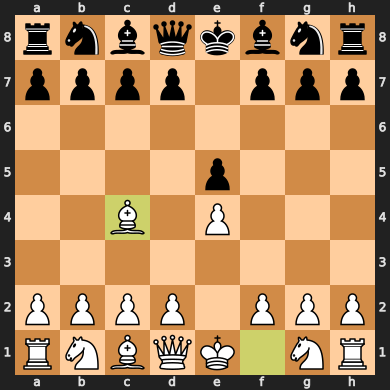

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_Z3iLvr4ootYgQMEZkF2aNrGe) *****
Moved bishop (♗) from f1 to c4.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I've moved my bishop from f1 to c4. Your move.

--------------------------------------------------------------------------------
Player White (to Player Black):

I've moved my bishop from f1 to c4. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I've moved my bishop from f1 to c4. Your move.

-----------------------------

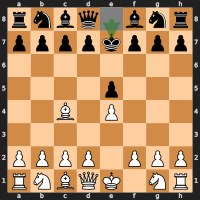

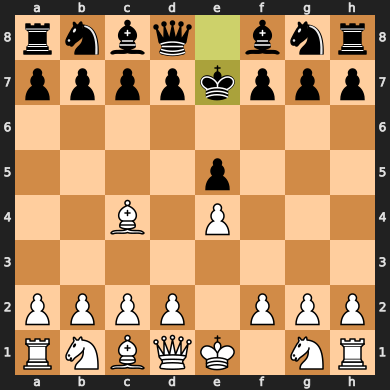

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_2TXjkmN7cxkU3aHx54TC6n09) *****
Moved king (♚) from e8 to e7.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I've moved my king from e8 to e7. Your move.

--------------------------------------------------------------------------------
Player Black (to Player White):

I've moved my king from e8 to e7. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I've moved my king from e8 to e7. Your move.

-------------------------------------

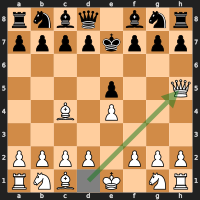

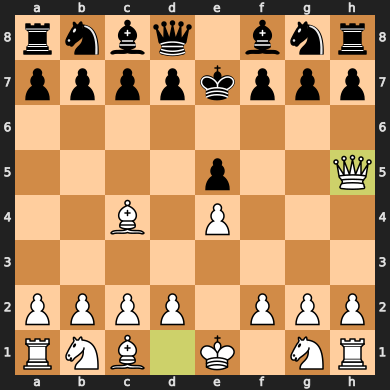

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_f4gOLCnvJNIW7IDxyzqeEUOa) *****
Moved queen (♕) from d1 to h5.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I moved my Queen from d1 to h5. Your move.

--------------------------------------------------------------------------------
Player White (to Player Black):

I moved my Queen from d1 to h5. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player Black):

I moved my Queen from d1 to h5. Your move.

------------------------------------------

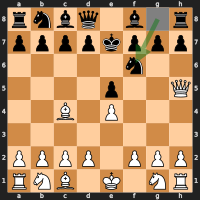

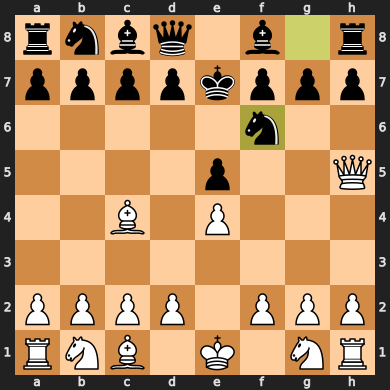

Board Proxy (to Player Black):

Board Proxy (to Player Black):

***** Response from calling tool (call_QAsqvYQ03LIysc9aUBW7cgob) *****
Moved knight (♞) from g8 to f6.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player Black (to Board Proxy):

I moved my Knight from g8 to f6. Your move.

--------------------------------------------------------------------------------
Player Black (to Player White):

I moved my Knight from g8 to f6. Your move.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

********************************************************************************
Starting a new chat....

********************************************************************************
Board Proxy (to Player White):

I moved my Knight from g8 to f6. Your move.

--------------------------------------

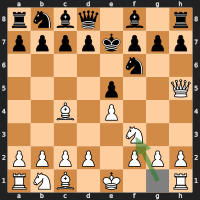

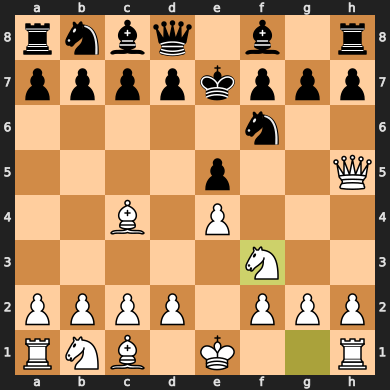

Board Proxy (to Player White):

Board Proxy (to Player White):

***** Response from calling tool (call_nl5FdNA6JXW1mgoSATnkeaQP) *****
Moved knight (♘) from g1 to f3.
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Player White (to Board Proxy):

I have moved my Knight from g1 to f3. Your move.

--------------------------------------------------------------------------------
Player White (to Player Black):

I have moved my Knight from g1 to f3. Your move.

--------------------------------------------------------------------------------


In [47]:
# Clear the board.
board = chess.Board()

chat_result = player_black.initiate_chat(
    player_white,
    message="Let's play chess! Your move.",
    max_turns=4,
)